In [2]:
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib_venn as pltv
import matplotlib.pyplot as plt

from ProjectTools import OpenBeds

In [6]:
dry = True

def column_dropper(df):
    redundant_columns = ["modification_type", "percentMeth", "strand", "modified_reads", "unmodified_reads"]
    return df.drop(columns=redundant_columns, errors="ignore")

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = OpenBeds.get_nanopore_twoMod(nano_2mod_path) # easier just to overwrite nano_mc
    wgbs_df = OpenBeds.get_wgbs(wgbs_bed_path)
    tab_df = OpenBeds.get_tab(tab_bed_path)

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    wgbs_df = OpenBeds.get_wgbs(wgbs_bed_path)
    tab_df = OpenBeds.get_tab(tab_bed_path)
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = OpenBeds.get_nanopore_twoMod(nano_2mod_path)

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df


filtered_nano_all = pd.merge(filter_on_depth(nano_mc_df).drop(columns="method"), filter_on_depth(nano_hmc_df).drop(columns="method"),
"inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC", "_5hmC"])
filtered_nano_all["method"] = "Nanopore"
filtered_nano_all["readCount"] = filtered_nano_all[["readCount_5mC", "readCount_5hmC"]].mean(axis=1)
filtered_nano_all.drop(columns=["readCount_5mC", "readCount_5hmC"], inplace=True)

filtered_wgbs_df = filter_on_depth(wgbs_df)
filtered_tab_df = filter_on_depth(tab_df)

def calculate_intersect(l, r, out):
    intersect = pd.merge(l, r, "inner", ["chromosome", "chromStart", "chromEnd"])
    excluding = pd.merge(intersect, out, "inner", ["chromosome", "chromStart", "chromEnd"])
    return len(intersect) - len(excluding) 

nano_n_wgbs = calculate_intersect(filtered_nano_all, filtered_wgbs_df, filtered_tab_df)
nano_n_tab = calculate_intersect(filtered_nano_all, filtered_tab_df, filtered_wgbs_df)
wgbs_n_tab = calculate_intersect(filtered_wgbs_df, filtered_tab_df, filtered_nano_all)

all_overlap = len(
    pd.merge(
        pd.merge(filtered_nano_all, filtered_wgbs_df,
        "inner", ["chromosome", "chromStart", "chromEnd"]), 
    filtered_tab_df, "inner", ["chromosome", "chromStart", "chromEnd"]))

just_nano = len(filtered_nano_all) - (nano_n_wgbs + nano_n_tab + all_overlap)
just_wgbs = len(filtered_wgbs_df) - (wgbs_n_tab + nano_n_wgbs + all_overlap)
just_tab = len(filtered_tab_df) - (wgbs_n_tab + nano_n_tab + all_overlap)

In [5]:
from pybedtools import BedTool
from ProjectTools import FeatIntersects

ref_features = BedTool('./feature_references/mm39_fig1_features.bed')
intergenic_bed = BedTool('./feature_references/fig1_features/mm39_intergenic.bed')

mc_bed = BedTool.from_dataframe(pd.concat([nano_mc_df, wgbs_df]))
hmc_bed = BedTool.from_dataframe(pd.concat([nano_hmc_df, tab_df]))

FileNotFoundError: File "./feature_references/mm39_fig1_features.bed" does not exist

In [ ]:
mc_intersects_df = FeatIntersects.find_type_intersects(mc_bed, ref_features, intergenic_bed)
hmc_intersects_df = FeatIntersects.find_type_intersects(hmc_bed, ref_features, intergenic_bed)

hmc_intersects_df.loc[hmc_intersects_df["method"] == "Nanopore 5hmC", "method"] = "Nanopore"
mc_intersects_df.loc[mc_intersects_df["method"] == "Nanopore 5mC", "method"] = "Nanopore"

In [ ]:
def generate_genome_average(mod_df):
    dummy_df = mod_df.copy()
    dummy_df["feature_type"] = "Genome-wide"

    dummy_df.loc[dummy_df["method"].str.contains("Nanopore"), "method"] = "Nanopore"
    return dummy_df

In [1]:
mc_allFeature_df = pd.concat([mc_intersects_df, generate_genome_average(mc_intersects_df)])

NameError: name 'pd' is not defined

In [3]:
from pybedtools import BedTool

all_bed = BedTool.from_dataframe(pd.concat([filtered_tab_df, filtered_wgbs_df, filtered_nano_all]))
ref_features = BedTool('./feature_references/fig1_features.bed')

feature_overlaps = BedTool.intersect(all_bed, ref_features, wb=True)
feature_overlaps_df = feature_overlaps.to_dataframe(names=["chromosome", "chromStart" ,"chromEnd" ,"readCount", "method", "strand", "thickStart", "thickEnd", "itemRgb"]).drop(columns=["strand", "thickStart", "thickEnd"]).rename(columns={"itemRgb":"feature"})

other_df = BedTool.intersect(all_bed, ref_features, v=True).to_dataframe(names=["chromosome", "chromStart" ,"chromEnd" ,"readCount", "method"])
other_df["feature"] = "Intergenic"

all_overlaps_df = pd.concat([feature_overlaps_df, other_df])
del other_df, feature_overlaps_df

all_overlaps_df.loc[all_overlaps_df["feature"].str.contains("CpG"), "feature"] = "CGI"

whole_genome_ref_df = pd.concat([filtered_tab_df, filtered_wgbs_df, filtered_nano_all])
whole_genome_ref_df["feature"] = "Genome-wide"

features_rel_genome_df = pd.concat([all_overlaps_df, whole_genome_ref_df])
del all_overlaps_df, whole_genome_ref_df

/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/pybedtools/bedtool.py:3714: DtypeWarning: Columns (5,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pandas.read_csv(self.fn, *args, sep="\t", **kwargs)
/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/pybedtools/bedtool.py:3714: DtypeWarning: Columns (5,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pandas.read_csv(self.fn, *args, sep="\t", **kwargs)


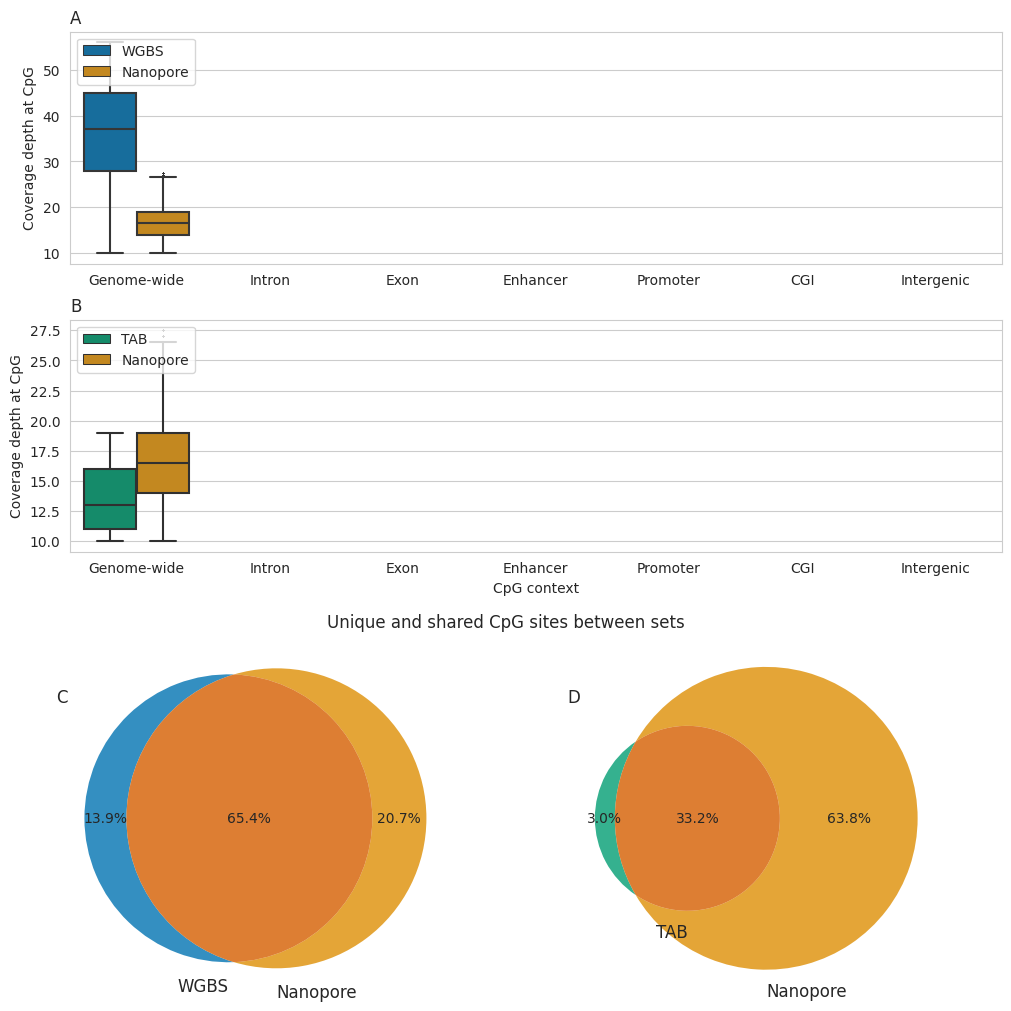

In [4]:
import matplotlib.gridspec as gridspec

sns.set_style("whitegrid")

fig0 = plt.figure(figsize=(10,10))
gs0 = gridspec.GridSpec(2, 1, fig0, height_ratios=[3,2])

fig1 = fig0.add_subfigure(gs0[0, :])
gs1 = gridspec.GridSpec(2, 1, fig1)

ax1 = fig1.add_subplot(gs1[0, :])
sns.boxplot(features_rel_genome_df.loc[(features_rel_genome_df["method"] == "Nanopore") | (features_rel_genome_df["method"] == "WGBS") & (features_rel_genome_df["feature"] != "Repeat")], 
x="feature", y="readCount", hue="method", ax=ax1, palette={
    "Nanopore" : sns.color_palette("colorblind", 4)[1], 
    "WGBS" : sns.color_palette("colorblind", 4)[0]}, 
    flierprops={
    "marker":"x", 
    "markersize" : 0.1},
    order=["Genome-wide", "Intron", "Exon", "Enhancer", "Promoter", "CGI", "Intergenic"])
sns.move_legend(ax1, "upper left", title=None)
ax1.tick_params("x")
ax1.set(xlabel=None, ylabel="Coverage depth at CpG")
ax1.set_title("A", loc="left")

ax2 = fig1.add_subplot(gs1[1, :], sharex=ax1)
sns.boxplot(features_rel_genome_df.loc[(features_rel_genome_df["method"] == "Nanopore") | (features_rel_genome_df["method"] == "TAB") & (features_rel_genome_df["feature"] != "Repeat")], 
x="feature", y="readCount", hue="method", ax=ax2, palette={
    "Nanopore" : sns.color_palette("colorblind", 4)[1], 
    "TAB" : sns.color_palette("colorblind", 4)[2]}, 
    flierprops={
        "marker":"x", 
        "markersize" : 0.1},
        order=["Genome-wide", "Intron", "Exon", "Enhancer", "Promoter", "CGI", "Intergenic"])
sns.move_legend(ax2, "upper left", title=None)
ax2.set(xlabel="CpG context", ylabel="Coverage depth at CpG")
ax2.tick_params("x")
ax2.set_title("B", loc="left")

fig2 = fig0.add_subfigure(gs0[1,:])
gs2 = gridspec.GridSpec(1, 2, fig2)

ax3 = fig2.add_subplot(gs2[0, 0])
v1 = pltv.venn2((just_wgbs, just_nano, nano_n_wgbs), set_labels=["WGBS", "Nanopore"], alpha=0.8, ax=ax3)
v1.get_label_by_id("10").set_text("{:.1%}".format((just_wgbs/(just_wgbs + just_nano + nano_n_wgbs))))
v1.get_patch_by_id("10").set_facecolor(sns.color_palette("colorblind", 4)[0])
v1.get_label_by_id("01").set_text("{:.1%}".format((just_nano/(just_wgbs + just_nano + nano_n_wgbs))))
v1.get_patch_by_id("01").set_facecolor(sns.color_palette("colorblind", 4)[1])
v1.get_label_by_id("11").set_text("{:.1%}".format((nano_n_wgbs/(just_wgbs + just_nano + nano_n_wgbs))))
v1.get_patch_by_id("11").set_facecolor(sns.color_palette("colorblind", 4)[3])
ax3.set_title("C", loc="left", y=0.8)

ax4 = fig2.add_subplot(gs2[0, 1])
v2 = pltv.venn2((just_tab, just_nano, nano_n_tab), set_labels=["TAB", "Nanopore"], alpha=0.8, ax=ax4)
v2.get_label_by_id("10").set_text("{:.1%}".format((just_tab/(just_tab + just_nano + nano_n_tab))))
v2.get_patch_by_id("10").set_facecolor(sns.color_palette("colorblind", 4)[2])
v2.get_label_by_id("01").set_text("{:.1%}".format((just_nano/(just_tab + just_nano + nano_n_tab))))
v2.get_patch_by_id("01").set_facecolor(sns.color_palette("colorblind", 4)[1])
v2.get_label_by_id("11").set_text("{:.1%}".format((nano_n_tab/(just_tab + just_nano + nano_n_tab))))
v2.get_patch_by_id("11").set_facecolor(sns.color_palette("colorblind", 4)[3])
ax4.set_title("D", loc="left", y=0.8)
fig2.suptitle("Unique and shared CpG sites between sets")

fig0.set_constrained_layout(True)
fig0.show()

In [5]:
len(filtered_nano_all)

917503

In [6]:
len(filtered_wgbs_df)

833511

In [7]:
features_rel_genome_df.loc[(features_rel_genome_df["method"] == "TAB") & (features_rel_genome_df["feature"] == "CGI"), "readCount"].median()

nan

In [8]:
filtered_wgbs_df["readCount"].median()

37.0

In [9]:
filtered_tab_df["readCount"].median()

13.0

In [10]:
len(filtered_tab_df)

396353

In [11]:
filtered_nano_all["readCount"].median()

16.5